# Deep learning regression models and k-fold validation

### a)	Data import / pre-processing: 

In [1]:
import numpy as np
import os
from zipfile import ZipFile

In [2]:
with ZipFile("soybean_images.zip","r") as zip_ref:
    zip_ref.extractall()

In [3]:
sample_dir = '/soybean_images/'

In [4]:
images = []
labels = []
for f in os.listdir(sample_dir):
    sample = np.load(sample_dir + str(f))

    images.append(sample['image'])
    labels.append(sample['y'])

print(np.asarray(images).shape)
print(np.asarray(labels).shape)

(22986, 9, 32, 32)
(22986,)


In [5]:
# storing the data as array in X (input features) and y (average yield) variables
X = np.asarray(images)
y = np.asarray(labels)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state=1)
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape), (X_test.shape, y_test.shape)

(((13791, 9, 32, 32), (13791,)),
 ((4597, 9, 32, 32), (4597,)),
 ((4598, 9, 32, 32), (4598,)))

In [7]:
# The shape of each file is (9, 32, 32) which we need to reshape into (32, 32, 9)
# as tensorflow expects the input for CNN in 
# (<number of images>, <img x_dim>, <img y_dim>, <number of channels>) 
x_train_reshaped = X_train.reshape(X_train.shape[0], 32, 32, 9)
x_test_reshaped = X_test.reshape(X_test.shape[0], 32, 32, 9)
x_val_reshaped = X_val.reshape(X_val.shape[0], 32, 32, 9)
input_shape = (32, 32, 9)

# b) Training and Justification

Importing necessary libraries

In [8]:
from numpy import sqrt
import tensorflow as tf
from tensorflow.keras import Sequential, callbacks, optimizers, backend
from tensorflow.keras.layers import Dense, Flatten

In [9]:
!pip install -q -U keras-tuner
import keras_tuner as kt

In [10]:
# determine the number of input features
n_features = x_train_reshaped.shape[3]
n_features

9

# MLP

In [11]:
def mlp_model(hp):
    mlp_model = Sequential()
    mlp_model.add(Flatten())
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    mlp_model.add(Dense(units=hp_units, activation='relu', kernel_initializer='he_normal', input_shape=(32, 32, 9)))
    mlp_model.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
    mlp_model.add(Dense(1))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    mlp_model.compile(optimizer=optimizers.Adam(learning_rate=hp_learning_rate), loss='mse')
    return mlp_model

In [12]:
early_stopping = callbacks.EarlyStopping(monitor='loss', patience=5)

In [13]:
tuner = kt.Hyperband(mlp_model,
                     objective="val_loss",
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='mlp_model')

INFO:tensorflow:Reloading Oracle from existing project my_dir\mlp_model\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\mlp_model\tuner0.json


In [14]:
tuner.search(x_train_reshaped, y_train, epochs=50, validation_data=(x_val_reshaped, y_val), callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 512 and the optimal learning rate for the optimizer
is 0.01.



In [15]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train_reshaped, y_train, epochs=50, validation_data=(x_val_reshaped, y_val))

val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
431/431 [==============================] - 12s 26ms/step - loss: 120.5496 - val_loss: 56.7445
Epoch 2/50
431/431 [==============================] - 12s 28ms/step - loss: 46.8372 - val_loss: 39.3802
Epoch 3/50
431/431 [==============================] - 11s 25ms/step - loss: 36.6783 - val_loss: 41.9665
Epoch 4/50
431/431 [==============================] - 10s 24ms/step - loss: 29.1207 - val_loss: 30.9087
Epoch 5/50
431/431 [==============================] - 10s 24ms/step - loss: 24.3938 - val_loss: 30.9036
Epoch 6/50
431/431 [==============================] - 11s 26ms/step - loss: 21.8587 - val_loss: 30.9458
Epoch 7/50
431/431 [==============================] - 11s 26ms/step - loss: 21.0735 - val_loss: 30.8274
Epoch 8/50
431/431 [==============================] - 12s 28ms/step - loss: 19.7598 - val_loss: 31.7019
Epoch 9/50
431/431 [==============================] - 10s 24ms/step - loss: 18.4019 - val_loss: 31.0660
Epoch 10/50
431/431 [==============================] - 10s 22ms

In [16]:
tuned_mlp_model = tuner.hypermodel.build(best_hps)

# Retrain the model
tuned_mlp_model.fit(x_train_reshaped, y_train, epochs=best_epoch, validation_data=(x_val_reshaped, y_val))

Epoch 1/12
431/431 [==============================] - 12s 25ms/step - loss: 108.3917 - val_loss: 41.7779
Epoch 2/12
431/431 [==============================] - 10s 23ms/step - loss: 38.8634 - val_loss: 33.8858
Epoch 3/12
431/431 [==============================] - 11s 25ms/step - loss: 31.0556 - val_loss: 36.7141
Epoch 4/12
431/431 [==============================] - 10s 24ms/step - loss: 28.9608 - val_loss: 33.6706
Epoch 5/12
431/431 [==============================] - 10s 24ms/step - loss: 25.3719 - val_loss: 31.1768
Epoch 6/12
431/431 [==============================] - 10s 24ms/step - loss: 23.6552 - val_loss: 32.7418
Epoch 7/12
431/431 [==============================] - 10s 22ms/step - loss: 22.4349 - val_loss: 32.8141
Epoch 8/12
431/431 [==============================] - 10s 23ms/step - loss: 21.4991 - val_loss: 30.7551
Epoch 9/12
431/431 [==============================] - 10s 23ms/step - loss: 20.0688 - val_loss: 33.2639
Epoch 10/12
431/431 [==============================] - 9s 22ms/

In [17]:
# initial_learning_rate = 0.01
# lr_schedule = optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100000,
#     decay_rate=0.96,
#     staircase=True)

In [18]:
# compile the model
# mlp_model.compile(optimizer=optimizers.Adam(learning_rate=lr_schedule), loss='mse')

In [19]:
tuned_mlp_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               4719104   
_________________________________________________________________
dense_7 (Dense)              (None, 10)                5130      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 4,724,245
Trainable params: 4,724,245
Non-trainable params: 0
_________________________________________________________________


In [20]:
predictions_val  = tuned_mlp_model.predict(x_val_reshaped)
predictions_val

array([[45.18808 ],
       [31.061745],
       [48.5673  ],
       ...,
       [52.0434  ],
       [52.666664],
       [30.410448]], dtype=float32)

### Evaluating the model

In [21]:
error = tuned_mlp_model.evaluate(x_val_reshaped, y_val, verbose=0)
print('MSE: %.3f, RMSE: %.3f' % (error, sqrt(error)))

MSE: 31.201, RMSE: 5.586


In [22]:
from sklearn.metrics import r2_score
r2_score(predictions_val, y_val)

0.6489151735200394

In [23]:
import matplotlib.pyplot as plt

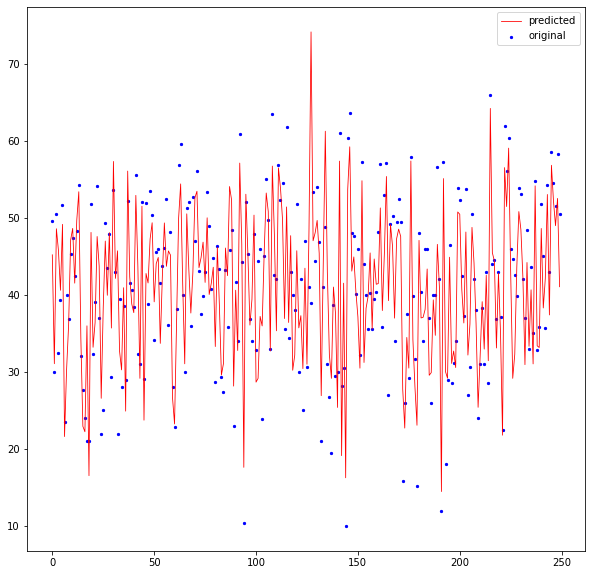

In [24]:
fig = plt.figure(figsize=(10, 10))
x_ax = range(len(predictions_val[:250]))
plt.scatter(x_ax, y_val[:250], s=5, color="blue", label="original")
plt.plot(x_ax, predictions_val[:250], lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

# CNN

In [25]:
from tensorflow.keras.layers import Conv2D, MaxPool2D

In [26]:
# determine the shape of the input images
in_shape = x_train_reshaped.shape[1:]
in_shape

(32, 32, 9)

In [27]:
def cnn_model(hp):
    cnn_model = Sequential()
    cnn_model.add(Conv2D(
        #adding filter 
        filters=hp.Int('conv_1_filter', min_value=32, max_value=256, step=32),
        # adding filter size or kernel size
        kernel_size=(3,3),
        activation='relu', 
        kernel_initializer='he_uniform', 
        input_shape=(32, 32, 9)))
    cnn_model.add(MaxPool2D((2, 2)))
    cnn_model.add(Conv2D(               
        filters=64,
        kernel_size=(3,3),
        activation='relu'))
    cnn_model.add(MaxPool2D((2, 2)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(32, activation='relu'))
    cnn_model.add(Dense(1))
   
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    cnn_model.compile(optimizer=optimizers.Adam(learning_rate=hp_learning_rate), loss='mse')
    return cnn_model

In [28]:
early_stopping = callbacks.EarlyStopping(monitor='loss', patience=5)

In [29]:
# initialising the keras tuner
tuner = kt.Hyperband(cnn_model,
                     objective="val_loss",
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='cnn_model')

INFO:tensorflow:Reloading Oracle from existing project my_dir\cnn_model\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\cnn_model\tuner0.json


In [30]:
tuner.search(x_train_reshaped, y_train, epochs=50, validation_data=(x_val_reshaped, y_val), callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first CNN
layer is {best_hps.get('conv_1_filter')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first CNN
layer is 256 and the optimal learning rate for the optimizer
is 0.01.



In [31]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train_reshaped, y_train, epochs=50, validation_data=(x_val_reshaped, y_val))

val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
431/431 [==============================] - 47s 108ms/step - loss: 570.0696 - val_loss: 60.9409
Epoch 2/50
431/431 [==============================] - 48s 112ms/step - loss: 50.5969 - val_loss: 53.1113
Epoch 3/50
431/431 [==============================] - 48s 110ms/step - loss: 42.9675 - val_loss: 37.1470
Epoch 4/50
431/431 [==============================] - 49s 114ms/step - loss: 38.3633 - val_loss: 42.1189
Epoch 5/50
431/431 [==============================] - 48s 111ms/step - loss: 34.6304 - val_loss: 34.4997
Epoch 6/50
431/431 [==============================] - 47s 110ms/step - loss: 31.4923 - val_loss: 36.6599
Epoch 7/50
431/431 [==============================] - 47s 108ms/step - loss: 31.7193 - val_loss: 33.8029
Epoch 8/50
431/431 [==============================] - 45s 104ms/step - loss: 31.0740 - val_loss: 31.5505
Epoch 9/50
431/431 [==============================] - 49s 113ms/step - loss: 28.6850 - val_loss: 32.8060
Epoch 10/50
431/431 [==============================] -

In [32]:
tuned_cnn_model = tuner.hypermodel.build(best_hps)

# Retrain the model
tuned_cnn_model.fit(x_train_reshaped, y_train, epochs=best_epoch, validation_data=(x_val_reshaped, y_val))

Epoch 1/30
431/431 [==============================] - 46s 105ms/step - loss: 360.4100 - val_loss: 48.8972
Epoch 2/30
431/431 [==============================] - 45s 105ms/step - loss: 47.7383 - val_loss: 41.6276
Epoch 3/30
431/431 [==============================] - 45s 105ms/step - loss: 39.5293 - val_loss: 38.0034
Epoch 4/30
431/431 [==============================] - 45s 105ms/step - loss: 39.0736 - val_loss: 37.4708
Epoch 5/30
431/431 [==============================] - 45s 105ms/step - loss: 32.6145 - val_loss: 35.0489
Epoch 6/30
431/431 [==============================] - 45s 105ms/step - loss: 28.4442 - val_loss: 36.8135
Epoch 7/30
431/431 [==============================] - 45s 105ms/step - loss: 27.0845 - val_loss: 30.8683
Epoch 8/30
431/431 [==============================] - 45s 105ms/step - loss: 25.1875 - val_loss: 33.7830
Epoch 9/30
431/431 [==============================] - 45s 104ms/step - loss: 23.9681 - val_loss: 45.7573
Epoch 10/30
431/431 [==============================] -

In [33]:
tuned_cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 256)       20992     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 64)        147520    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                73760     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                

In [34]:
predictions_val  = tuned_cnn_model.predict(x_val_reshaped)
predictions_val

array([[41.317554],
       [34.113087],
       [46.94695 ],
       ...,
       [56.034313],
       [56.792316],
       [33.229683]], dtype=float32)

# Evaluating the CNN model on validation data

In [35]:
error = tuned_cnn_model.evaluate(x_val_reshaped, y_val, verbose=0)
print('MSE: %.3f, RMSE: %.3f' % (error, sqrt(error)))

MSE: 30.041, RMSE: 5.481


In [36]:
# r2 score for cnn model
r2_score(predictions_val, y_val)

0.7244602606393471

In [37]:
# initial_learning_rate = 0.01
# lr_schedule = optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100000,
#     decay_rate=0.96,
#     staircase=True)

In [38]:
# define loss and optimizer
# cnn_model.compile(optimizer=optimizers.Adam(learning_rate=lr_schedule), loss='mse')

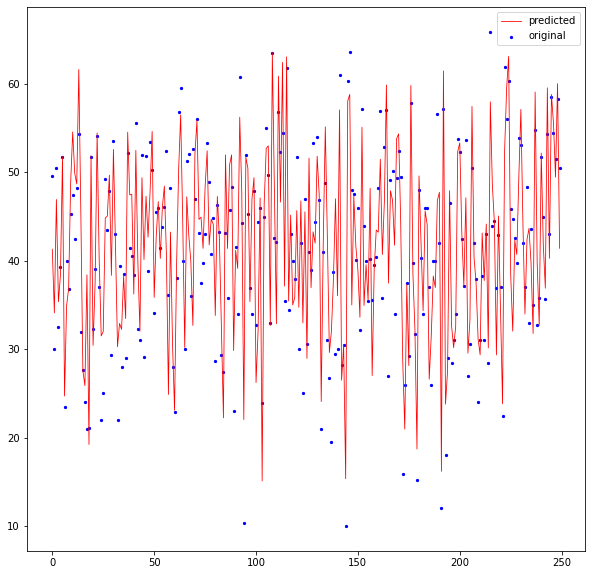

In [39]:
fig = plt.figure(figsize=(10, 10))
x_ax = range(len(predictions_val[:250]))
plt.scatter(x_ax, y_val[:250], s=5, color="blue", label="original")
plt.plot(x_ax, predictions_val[:250], lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

# C) Cross Validation: K-Fold

In [40]:
# splitting the data again for k-fold 
# X_test and y_test will be kept aside for final evaluation
X_main, X_test, y_main, y_test = train_test_split(X, y, test_size = 0.2)

In [41]:
# Channels go last for TensorFlow backend
X_main_reshaped = X_main.reshape(X_main.shape[0], 32, 32, 9)

### MLP with K-fold

In [42]:
from sklearn.model_selection import KFold
# code referenced from [4] (scikit-learn, 2021)
n_split=5
# Define per-fold score containers
loss_per_fold = []
# k-fold cross validation model
fold_no = 1
for train_index,val_index in KFold(n_split).split(X_main_reshaped):
    x_train,x_val=X_main_reshaped[train_index],X_main_reshaped[val_index]
    y_train,y_val=y_main[train_index],y_main[val_index]
   
    #clear 
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    # fit data to model
    history = tuned_mlp_model.fit(x_train, y_train,epochs=20)
    # evalutate metrics
    scores = tuned_mlp_model.evaluate(x_val, y_val, verbose=0)
    print(f'Score for fold {fold_no}: {tuned_mlp_model.metrics_names} of {scores}')
    loss_per_fold.append(scores)
    # increase fold number
    fold_no = fold_no +1

Epoch 1/20
460/460 [==============================] - 10s 21ms/step - loss: 23.9712
Epoch 2/20
460/460 [==============================] - 10s 21ms/step - loss: 20.0587
Epoch 3/20
460/460 [==============================] - 10s 21ms/step - loss: 18.6782
Epoch 4/20
460/460 [==============================] - 10s 21ms/step - loss: 17.1700
Epoch 5/20
460/460 [==============================] - 10s 21ms/step - loss: 16.1900
Epoch 6/20
460/460 [==============================] - 10s 21ms/step - loss: 15.6856
Epoch 7/20
460/460 [==============================] - 10s 21ms/step - loss: 15.3743
Epoch 8/20
460/460 [==============================] - 10s 21ms/step - loss: 14.5159
Epoch 9/20
460/460 [==============================] - 10s 21ms/step - loss: 13.9147
Epoch 10/20
460/460 [==============================] - 10s 22ms/step - loss: 13.5854
Epoch 11/20
460/460 [==============================] - 10s 22ms/step - loss: 13.5660
Epoch 12/20
460/460 [==============================] - 10s 21ms/step - los

In [43]:
# == Provide average scores ==
print('-----------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(loss_per_fold)):
    print('-------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]}')
print('-------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('-------------------------------------------------------------')

-----------------------------------------------------------------
Score per fold
-------------------------------------------------------------
> Fold 1 - Loss: 26.824838638305664
-------------------------------------------------------------
> Fold 2 - Loss: 16.291236877441406
-------------------------------------------------------------
> Fold 3 - Loss: 9.908976554870605
-------------------------------------------------------------
> Fold 4 - Loss: 7.965734958648682
-------------------------------------------------------------
> Fold 5 - Loss: 5.987198829650879
-------------------------------------------------------------
Average scores for all folds:
> Loss: 13.395597171783447
-------------------------------------------------------------


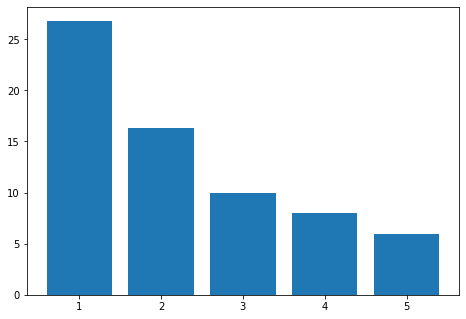

In [44]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar([1, 2, 3, 4, 5],loss_per_fold)
plt.show()

### CNN with K-fold

In [45]:
from sklearn.model_selection import KFold
# code referenced from [4] (scikit-learn, 2021)
n_split=5
# Define per-fold score containers
loss_per_fold = []
# k-fold cross validation model
fold_no = 1
for train_index,val_index in KFold(n_split).split(X_main_reshaped):
    x_train,x_val=X_main_reshaped[train_index],X_main_reshaped[val_index]
    y_train,y_val=y_main[train_index],y_main[val_index]
     #clear 
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    # fit data to model
    history = tuned_cnn_model.fit(x_train, y_train,epochs=20)
    # evalutate metrics
    scores = tuned_cnn_model.evaluate(x_val, y_val, verbose=0)
    print(f'Score for fold {fold_no}: {tuned_cnn_model.metrics_names} of {scores}')
    loss_per_fold.append(scores)
    # increase fold number
    fold_no = fold_no +1

Epoch 1/20
460/460 [==============================] - 46s 100ms/step - loss: 21.7932
Epoch 2/20
460/460 [==============================] - 46s 99ms/step - loss: 18.5699
Epoch 3/20
460/460 [==============================] - 46s 99ms/step - loss: 16.6221
Epoch 4/20
460/460 [==============================] - 46s 99ms/step - loss: 15.4752
Epoch 5/20
460/460 [==============================] - 46s 99ms/step - loss: 14.4405
Epoch 6/20
460/460 [==============================] - 46s 99ms/step - loss: 14.0049
Epoch 7/20
460/460 [==============================] - 47s 101ms/step - loss: 13.4371
Epoch 8/20
460/460 [==============================] - 47s 103ms/step - loss: 12.9852
Epoch 9/20
460/460 [==============================] - 46s 100ms/step - loss: 12.6144
Epoch 10/20
460/460 [==============================] - 46s 99ms/step - loss: 11.9894
Epoch 11/20
460/460 [==============================] - 46s 100ms/step - loss: 11.5965
Epoch 12/20
460/460 [==============================] - 46s 99ms/step 

In [46]:
# == Provide average scores ==
print('-----------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(loss_per_fold)):
    print('-------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]}')
print('-------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('-------------------------------------------------------------')

-----------------------------------------------------------------
Score per fold
-------------------------------------------------------------
> Fold 1 - Loss: 24.586746215820312
-------------------------------------------------------------
> Fold 2 - Loss: 16.2941951751709
-------------------------------------------------------------
> Fold 3 - Loss: 12.600712776184082
-------------------------------------------------------------
> Fold 4 - Loss: 9.61940860748291
-------------------------------------------------------------
> Fold 5 - Loss: 7.704930782318115
-------------------------------------------------------------
Average scores for all folds:
> Loss: 14.161198711395263
-------------------------------------------------------------


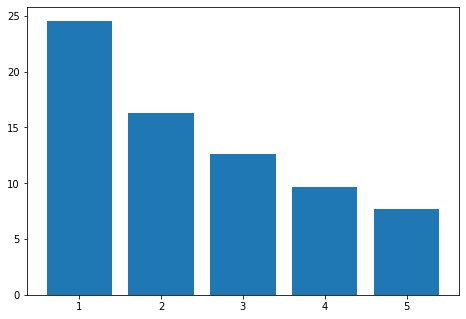

In [47]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar([1, 2, 3, 4, 5],loss_per_fold)
plt.show()

# Predicting over test data

In [48]:
X_test_reshaped = X_test.reshape(X_test.shape[0], 32, 32, 9)

In [49]:
#predicting on test data
predictions_mlp_test  = tuned_mlp_model.predict(X_test_reshaped)
predictions_cnn_test  = tuned_cnn_model.predict(X_test_reshaped)

In [50]:
# evaluate the MLPmodel
print("MLP Results:")
error = tuned_mlp_model.evaluate(X_test_reshaped, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f' % (error, sqrt(error)))
print(r2_score(predictions_mlp_test, y_test))

# evaluate the CNN model
print("CNN Results:")
error = tuned_cnn_model.evaluate(X_test_reshaped, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f' % (error, sqrt(error)))
print(r2_score(predictions_cnn_test, y_test))


MLP Results:
MSE: 36.835, RMSE: 6.069
0.6866333270049141
CNN Results:
MSE: 25.723, RMSE: 5.072
0.7723077991805609


# References:

[1] https://www.facebook.com/MachineLearningMastery (2019). TensorFlow 2 Tutorial: Get Started in Deep Learning With tf.keras. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/ [Accessed 3 Nov. 2021].

[2]Introduction to the Keras Tuner (2018). Introduction to the Keras Tuner  |  TensorFlow Core. [online] TensorFlow. Available at: https://www.tensorflow.org/tutorials/keras/keras_tuner [Accessed 3 Nov. 2021].

[3] Convolutional Neural Network (CNN (2021). Convolutional Neural Network (CNN)  |  TensorFlow Core. [online] TensorFlow. Available at: https://www.tensorflow.org/tutorials/images/cnn [Accessed 3 Nov. 2021].

[4] scikit-learn. (2021). sklearn.model_selection.KFold. [online] Available at: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html [Accessed 7 Nov. 2021].
